# Intro

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df  = pd.read_csv("./dataset/hotels_train.csv")
df = df.drop(columns=['reservation_status_date'])
df.head()

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,id,is_canceled
0,City Hotel,49,2016,September,37,5,1,2,1,0.0,...,No Deposit,9.0,NaN,0,Transient,115.5,0,1,7aa4cc6b-b92c-4061-b21d-4f9e0cac4689,1
1,Resort Hotel,4,2015,October,44,31,0,1,2,0.0,...,No Deposit,NaN,NaN,0,Transient,42.0,1,0,b1428f80-c56c-4ae4-91a9-6962edae08b1,0
2,City Hotel,25,2016,October,42,13,0,1,2,2.0,...,No Deposit,9.0,NaN,0,Transient,229.0,0,2,2226c018-ea20-4c4e-8f71-ea66aee70d7c,0
3,City Hotel,26,2016,December,51,12,2,5,2,0.0,...,Non Refund,154.0,NaN,0,Transient,75.0,0,0,314f56dc-2e4d-4298-9bdd-27bb008bffff,1
4,City Hotel,104,2017,March,12,19,2,5,2,0.0,...,No Deposit,20.0,NaN,0,Transient-Party,75.0,0,1,28c75445-c603-413a-babf-ad377018b592,0


In [3]:
df.columns[:11] # LUCHO

Index(['hotel', 'lead_time', 'arrival_date_year', 'arrival_date_month',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies'],
      dtype='object')

In [4]:
df['is_canceled'].value_counts(normalize=True)

0    0.50025
1    0.49975
Name: is_canceled, dtype: float64

Lo primero a tener en cuenta en el dataset de entrenamiento es que (casi) la mitad de los registros son de cancelaciones y la otra mitad no. Esto nos dice que al analizar independientemente una variable, esta no va a tener **individualmente** una relación con la cancelación de la reservación si tiene mitad de registros de cancelaciones y la otra mitad no cancelaciones.

Esto no quiere decir necesariamente que la mitad de las reservaciones fueron canceladas, sino más bien que fueron seleccionadas para que haya la misma cantidad de registros de ambas para su análisis.

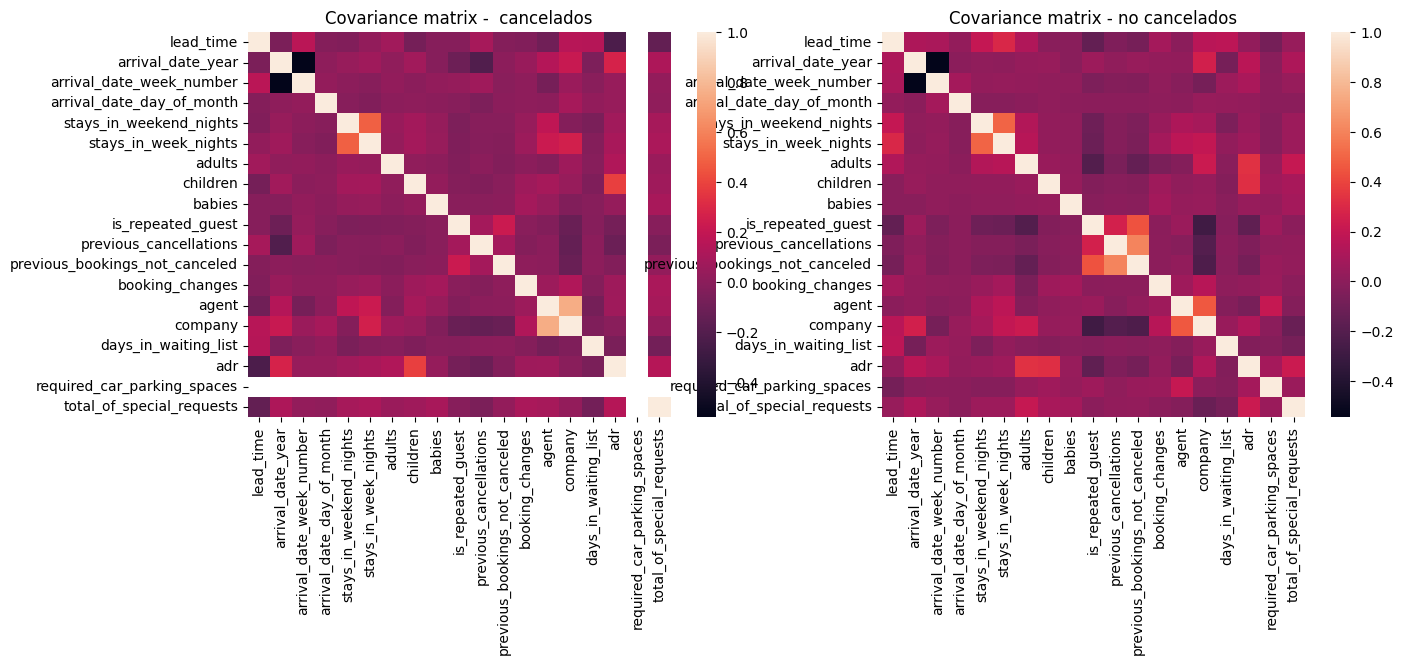

In [5]:
df_cancelado = df[df.is_canceled == 1]
df_no_cancelado = df[df.is_canceled == 0]

corr_can = df_cancelado.drop("is_canceled", axis=1).corr(numeric_only=True)
#corr_can = df_cancelado['adr', 'lead_time', 'people'].corr(numeric_only=True)
corr_no_can = df_no_cancelado.drop("is_canceled", axis=1).corr(numeric_only=True)

fig, ax = plt.subplots(1, 2, figsize=(15,5))

sns.heatmap(corr_can,
            annot=False,
            ax=ax[0])
ax[0].set_title('Covariance matrix -  cancelados')

sns.heatmap(corr_no_can,
            annot=False,
            ax=ax[1])
ax[1].set_title('Covariance matrix - no cancelados')

plt.show()

# Variables

1. **Hotel**: variable categórica que nos dice en que hotel fue hecha la reserva. Los posibles valores que puede tomar son:
    - City Hotel
    - Resort Hotel. 

No presenta valores faltantes.

Text(0.5, 1.0, 'cantidad de reservas por hotel')

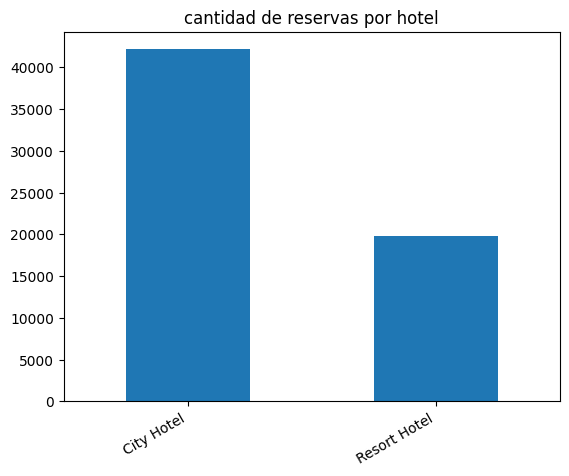

In [6]:
df['hotel'].value_counts().plot(kind='bar')
plt.xticks(rotation=30,horizontalalignment='right')
plt.title('cantidad de reservas por hotel')

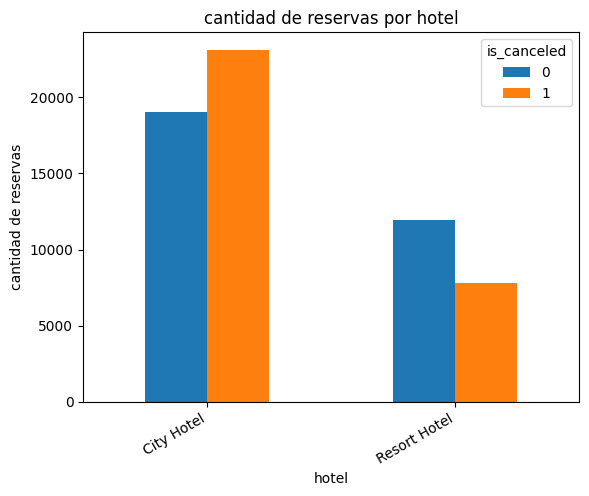

In [7]:
pd.crosstab(df.hotel, df.is_canceled).plot(kind='bar')
plt.xticks(rotation=30,horizontalalignment='right')
plt.ylabel('cantidad de reservas')
plt.title('cantidad de reservas por hotel')
plt.show()

Observamos que es una variable importante con relación al problema, ya que de hecho se podrían hacer estudios separados para cada hotel. Pero lo más importante es que el 'City Hotel' presenta una significante cantidad superior de reservas canceladas, mientras que el 'Resort Hotel' es al contrario, presenta más reservasa no canceladas.

Es muy fácil hacer un encoding para las categorías, ya que se trata de un caso binario. Creamos una nueva variable y le asignamos 1 al 'Resort Hotel' y 0 al 'City Hotel'

In [8]:
df['hotel_encoding'] = np.where(df['hotel'] == 'Resort Hotel', 1, 0)

# Dates (fechas)

2. `stays_in_week_nights`: Variable numérica (entero) que nos dicen cuantas noches de **días de semana** se quedan los huéspedes.
    - *Moda:* 2
    - *Media:* 2.510
    - *Mediana:* 2
    
3. `stays_in_weekend_nights`: Variable numérica (entero) que nos dice cuantas noches de **fin de semana** se quedan los huéspedes. 
    - *Moda:* 0
    - *Media:* 0.9241
    - *Mediana:* 1

<Axes: >

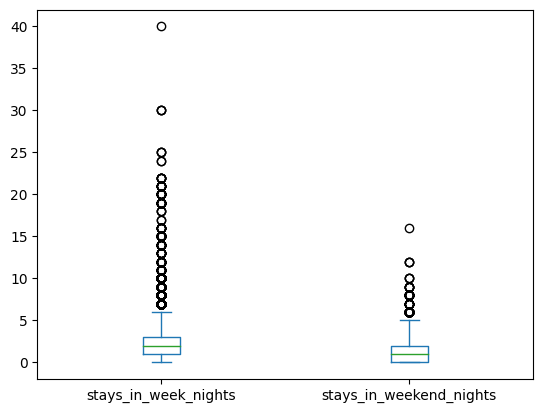

In [9]:
df[['stays_in_week_nights', 'stays_in_weekend_nights']].plot(kind='box')

4. `arrival_date_year`: variabe numérica nos dice el año para el cual se reservó la habitación. Los valores están entre 2015 y 2017

Si tenemos en cuenta que queremos crear un modelo que pueda predecir si una nueva reserva va a ser cancelada o no, es inútil entrenar a nuestro modelo explicitando los años anteriores. Es decir, no queremos encontrar un patrón con respecto a un año específico, ya que el hotel no va a volver a recibir reservaciones de un año que ya pasó.
En cambio queremos encontrar patrones que generalicen a cualquier año y ayuden al modelo a determinar si la reserva va a ser cancelada. Por ejemplo, encontrando que a principios de año se producen más cancelaciones que a final de año, o algo por el estilo.

Por estas razones creemos que la variable `arrival_date_year` es irrelevante para el análisis.

4. `arrival_date_week_number`: variable numérica que nos indica la semana del año para la cual reservaron los huéspedes. 
    - *Moda:* 33
    - *Media:* 27.2
    - *Mediana:* 28

Podemos plottear la distribucion de reservaciones canceladas y no canceladas durante todo el año:

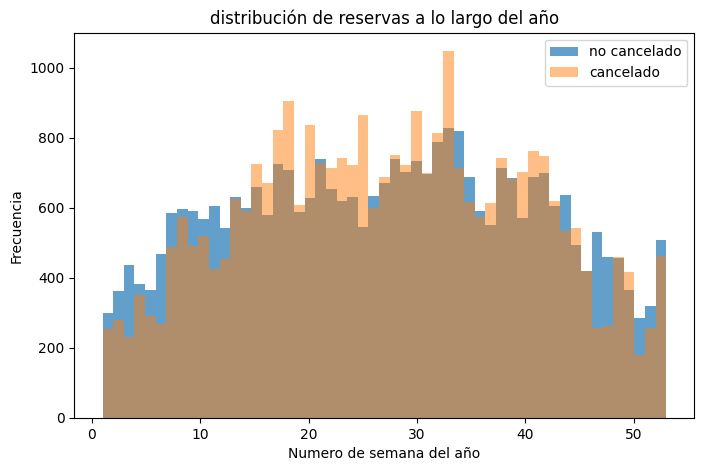

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
df.loc[df.is_canceled == 0, 'arrival_date_week_number'].plot(kind='hist', bins=53, alpha=0.7, ax=ax, label='no cancelado')
df.loc[df.is_canceled == 1, 'arrival_date_week_number'].plot(kind='hist', bins=53, alpha=0.5, ax=ax, label='cancelado')
ax.legend()
ax.set_xlabel("Numero de semana del año")
ax.set_ylabel("Frecuencia")
ax.set_title("distribución de reservas a lo largo del año")
plt.show()

5. `arrival_date_month`: es una variable categorica que nos indica el mes para el cual reservaron:

Podemos realizar un análisis parecido como con `arrival_date_week_number`, pero para cada mes:

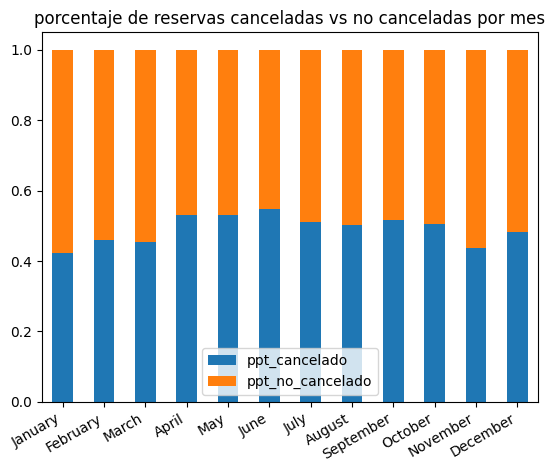

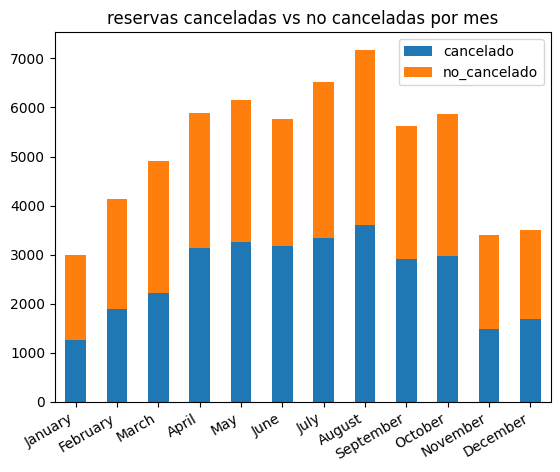

In [11]:
dd = pd.DataFrame({
    'cancelado': df.loc[df.is_canceled == 1, 'arrival_date_month'].value_counts(),
    'no_cancelado': df.loc[df.is_canceled == 0, 'arrival_date_month'].value_counts(),
},index= ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])

dd['ppt_cancelado']  =  dd['cancelado']  / (dd['cancelado'] + dd['no_cancelado'])
dd['ppt_no_cancelado']  =  dd['no_cancelado']  / (dd['cancelado'] + dd['no_cancelado'])

dd[['ppt_cancelado', 'ppt_no_cancelado']].plot(kind='bar', stacked=True)
plt.title("porcentaje de reservas canceladas vs no canceladas por mes")
plt.xticks(rotation=30, horizontalalignment='right')

dd[['cancelado', 'no_cancelado']].plot(kind='bar', stacked=True)
plt.title("reservas canceladas vs no canceladas por mes")
plt.xticks(rotation=30, horizontalalignment='right')
plt.show()

6. `arrival_date_day_of_month`: variable numérica que nos indica para que día del mes llegan los huéspedes.
    - *Moda:* 17
    - *Media:* 15.78
    - *Mediana:* 16

utilizando la variable `arrival_date_day_of_month` podemos analizar la distribucion de las reservaciones para cada mes:

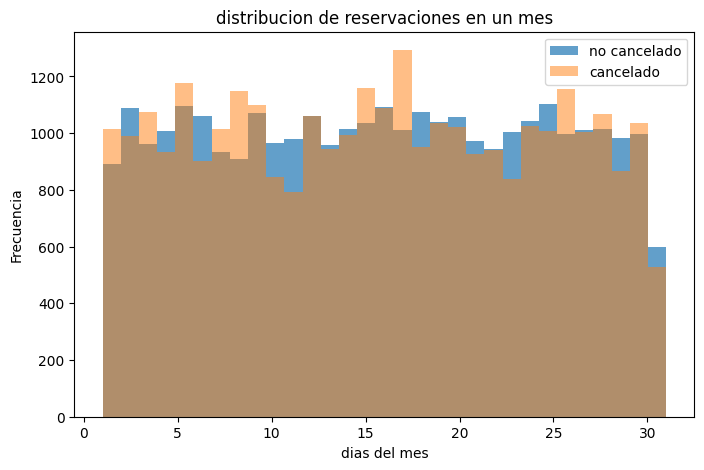

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
df.loc[df.is_canceled == 0, 'arrival_date_day_of_month'].plot(kind='hist', bins=31, alpha=0.7, ax=ax, label='no cancelado')
df.loc[df.is_canceled == 1, 'arrival_date_day_of_month'].plot(kind='hist', bins=31, alpha=0.5, ax=ax, label='cancelado')
ax.legend()
ax.set_xlabel("dias del mes")
ax.set_ylabel("Frecuencia")
ax.set_title("distribucion de reservaciones en un mes")
plt.show()

A simple vista no parece haber días en los que hayan más reservas, canceladas o no canceladas. Algo a tener en cuenta es que `arrival_date_day_of_month` y `arrival_date_month` pueden reconstruir a `arrival_date_week_number` perfectamente. Esto quiere decir que esta última variable esta implícita en las otras dos, por lo que en principio podríamos omitirla. O podríamos utilizar la de las semanas en lugar de las otras 2, si no queremos que el modelo quede ajustado a los meses y dias del mes.

In [13]:
#datetime = df['arrival_date_year'].astype("string") + "-" + df['arrival_date_month'].astype("string") + "-" + df['arrival_date_day_of_month'].astype("string")
#df['arrival_date'] = pd.to_datetime(datetime, format="%Y-%B-%d")

In [14]:
df['lead_time'].describe()
#df['lead_time'].mode()

count    61913.000000
mean       112.248187
std        110.717953
min          0.000000
25%         23.000000
50%         78.000000
75%        172.000000
max        629.000000
Name: lead_time, dtype: float64

7. `lead_time`: variable numérica que nos indica el numero de dias desde la reservación hasta la fecha de llegada al hotel.
    - *Moda:* 0
    - *Media:* 112.2
    - *Mediana:* 78

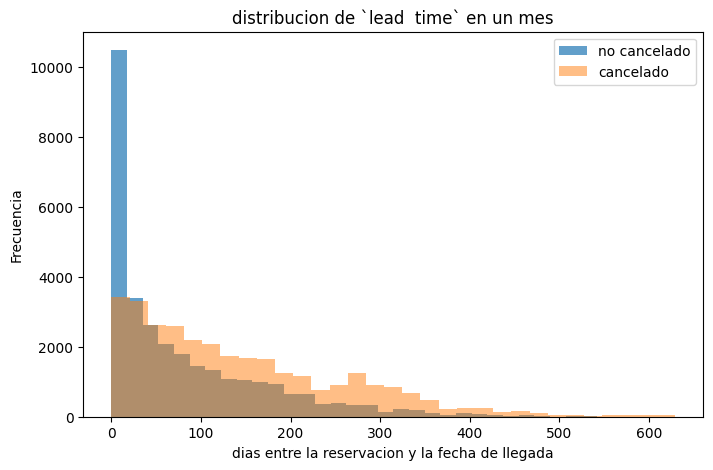

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
df.loc[df.is_canceled == 0, 'lead_time'].plot(kind='hist', bins=31, alpha=0.7, ax=ax, label='no cancelado')
df.loc[df.is_canceled == 1, 'lead_time'].plot(kind='hist', bins=31, alpha=0.5, ax=ax, label='cancelado')
ax.legend()
ax.set_xlabel("dias entre la reservacion y la fecha de llegada")
ax.set_ylabel("Frecuencia")
ax.set_title("distribucion de `lead  time` en un mes")
plt.show()

observamos como las reservas que se hacen el mismo dia de la llegada (lead time == 0) **no suelen ser canceladas**. Esto se puede deber a que llegan al hotel sin una reserva, y al hacerlo en el momento, no la van a cancelar. En cambio si la reserva se hace con mucha antelación (más de 100 dias), la **tendencia suele ser que la reserva sea cancelada**.  Por estas razones,  a priorir `lead_time` parece ser un gran predictor de `is_canceled`.

In [16]:
def scatter_plot(x, y):
    colors = ['r', 'y']
    label = ['no cancelado', 'cancelado']

    fig, ax = plt.subplots()
    for i in range(2):
        df[df.is_canceled==i].plot(kind='scatter', x=x, y=y, c=colors[i], label=label[i], ax=ax)

    ax.legend()

# children, babies, adults  

10. `adults`, `children`, `babies`: variables numéricas que cuentan la cantidada de adultos, nenes y bebes registrados en la reserva.

In [17]:
df[['adults', 'children', 'babies']].describe()

,adults,children,babies
count,61913.000000,61909.000000,61913.000000
mean,1.862791,0.104896,0.007155
std,0.589066,0.402847,0.092158
min,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000
50%,2.000000,0.000000,0.000000
75%,2.000000,0.000000,0.000000
max,55.000000,10.000000,9.000000


Observamos como estas 3 variables varían muy poco, no solo por su bajo desvío estándar (menores que 1), sino porque desde el mínimo hasta el cuantil 75% los valores son los mismos.
Esto podemos verlo en un dispersograma, ya que están todas en su mayoría concentradas en un lugar, y un par de valores atípicos alejados:

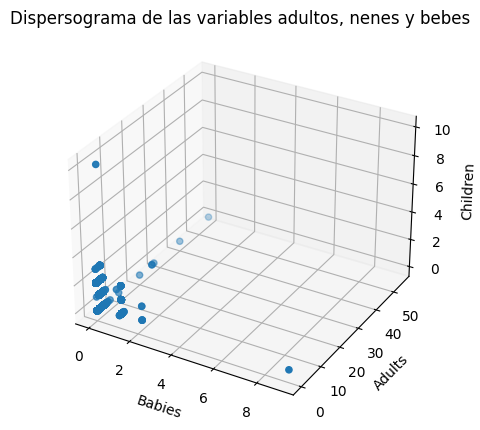

In [18]:
fig = plt.figure(figsize=(5, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(df.babies,df.adults,df.children)
ax.set_ylabel('Adults')
ax.set_xlabel('Babies')
ax.set_zlabel('Children')

plt.title('Dispersograma de las variables adultos, nenes y bebes')
plt.show()

In [19]:
df[['adults', 'children', 'babies']].isnull().sum() * 100 / len(df.index)

adults      0.000000
children    0.006461
babies      0.000000
dtype: float64

In [20]:
df[df['children'].isna() == True][['children', 'adults', 'babies']]

,children,adults,babies
27359,NaN,3,0
32654,NaN,2,0
50323,NaN,2,0
58511,NaN,2,0


El unico que tiene datos nulos (nan) es la columna `children`.  Como la fuente nos asegura que no hay missing data ("The PMS assured no missing data exists in its database tables") y viendo que se trata de solo 4 registros, vamos a suponer que se trata de que no presentan niños, ya que es lo que tiene mas sentido (no completaron el espacio) y ademas es la mediana de la variable children. 

In [21]:
df['children'] = df['children'].replace(np.nan, 0)

In [22]:
len(df[df['adults'] == 0])

197

Algo a tener en cuenta, es que hay 197 registros que no presentan adultos. No aclara en el paper si es posible o no que hagan niños la reservacion, pero observamos que son todos en su mayoria del city hotel:

In [23]:
pd.crosstab(df[df['adults'] == 0]['hotel'], df['is_canceled'])

is_canceled,0,1
hotel,,
City Hotel,117,75
Resort Hotel,5,0


Asi que al parecer el city hotel permite que niños/adolescentes hagan reservaciones, por lo que en principio (por análisis lógico) no vamos a removerlos del dataset.

Lo que si vamos a eliminar del dataset son los registros en los cuales no se reservan personas (las tres variables son cero), ya que son claramente errores (MCAR):

In [24]:
sin_personas = df[(df['children'] == 0) & (df['adults'] == 0) & (df['babies'] == 0)]
print(len(sin_personas))

76


In [25]:
df = df.drop(index=sin_personas.index)

Al observar el output de `describe()`, nos damos cuenta que el IQR de los tres campos no tiene largo (ya que los cuantiles 25% y 75% son iguales en los tres campos), por lo que en principio es imposible usar la regla de la altura del IQR  para detectar outliers.  

<Axes: >

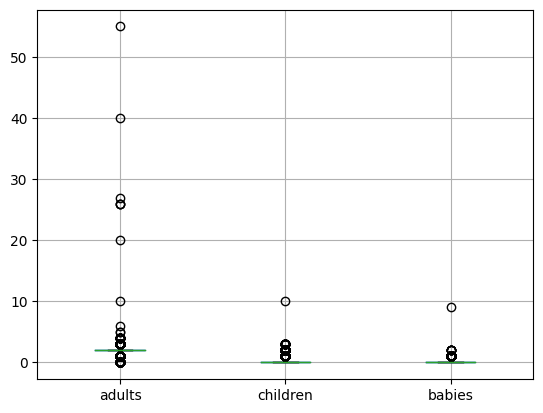

In [26]:
df[['adults', 'children', 'babies']].boxplot()

Por lo que podemos utilizar el z-score, para cada variable para encontrar sus outliers.

In [27]:
def z_score(x):
    return (x - x.mean()) / x.std()

umbral = 3

df[np.abs(z_score(df['adults'])) > umbral]['adults'].value_counts()

0     121
4      30
26      3
5       2
40      1
20      1
6       1
10      1
27      1
55      1
Name: adults, dtype: int64

In [ ]:
plt.boxplot(df[['adults', 'babies', 'children']])
plt.show()

In [ ]:
df[df['adults'] == 0][[ 'hotel', 'children', 'babies']].value_counts()

In [ ]:
a = (df['adults'] - df['adults'].mean()) / df['adults'].std()


df[~((a > -3)  & (a < 3))]['adults'].value_counts()

In [ ]:
pd.crosstab(df['children'], df['is_canceled'])
pd.crosstab(df['babies'], df['is_canceled'])
df['has_kids'] = (df['children'] > 0) | (df['babies'] > 0)
pd.crosstab(df['has_kids'], df['is_canceled'])

In [94]:
import scipy as sc

def mahal_dists(X):
    sample_X = X.sample(frac=0.1)
    mu = sample_X.mean()
    X_diff = X - mu
    X_diff = X_diff.values.T
    cov = np.cov(sample_X.values.T)
    inv_cov = np.linalg.inv(cov)
    W = sc.linalg.sqrtm(inv_cov)
    Wx = np.matmul(W, X_diff)
    return np.array([np.dot(Wx[:, i], Wx[:, i]) for i in range(Wx.shape[1])])

def z_score(x):
    return (x - x.mean()) / x.std()

def m_score(x):
    m = np.median(x)
    mad = np.median(np.abs(x - m))
    return 0.6756 * (x - m) / np.median(np.abs(x - m))


def IQR(x):
    Q1_altura=np.quantile(df.required_car_parking_spaces,0.25)
    Q3_altura=np.quantile(df.required_car_parking_spaces,0.75)

    #Rango intercuartil
    return Q3_altura-Q1_altura

In [ ]:
np.array([1,2,3]).

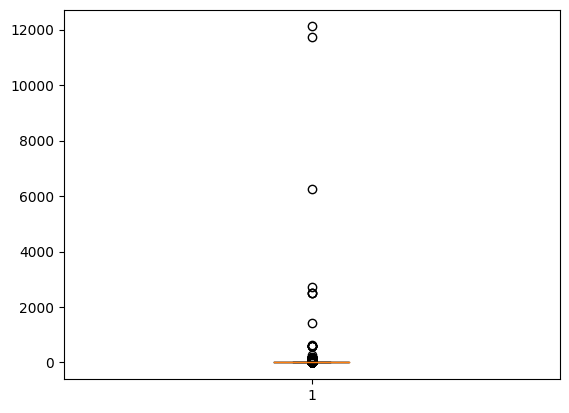

In [56]:
plt.boxplot(mahal_dists(df[['children', 'babies', 'adults']]))
plt.show()

In [58]:
df[mahal_dists(df[['children', 'babies', 'adults']]) > 300][['children', 'babies', 'adults']]

,children,babies,adults
4064,0.0,0,40
6675,1.0,2,2
11830,0.0,0,20
12659,0.0,9,1
14391,0.0,2,2
19146,0.0,0,26
38305,0.0,0,26
38639,0.0,2,2
47353,0.0,2,2
47646,0.0,2,2


In [47]:
mahal_dists(df[['children', 'babies', 'adults']]).mean()

4.244162537499696

In [57]:
from sklearn.covariance import EmpiricalCovariance
attrs = ['adults', 'children', 'babies']

emp_cov = EmpiricalCovariance().fit(df[attrs])

df['mahalanobis']  = emp_cov.mahalanobis(df[attrs])

df[df['mahalanobis'] > 300][attrs]

,adults,children,babies
4064,40,0.0,0
6675,2,1.0,2
11830,20,0.0,0
12659,1,0.0,9
14391,2,0.0,2
19146,26,0.0,0
38305,26,0.0,0
38639,2,0.0,2
47353,2,0.0,2
47646,2,0.0,2


In [73]:
a =  z_score(df['lead_time'])
df[np.abs(a) > 3]['lead_time']

15       465
51       489
95       454
426      521
576      626
        ... 
61579    517
61695    468
61761    496
61783    454
61790    538
Name: lead_time, Length: 732, dtype: int64

In [72]:
a =  z_score(df['adr'])
df[np.abs(a) > 3]['adr']

238      302.5
307      279.0
320      289.6
439      307.0
481      269.3
         ...  
61689    247.0
61745    300.4
61830    271.0
61834    305.0
61889    263.0
Name: adr, Length: 775, dtype: float64

,stays_in_week_nights,stays_in_weekend_nights,days_in_waiting_list
518,2,0,391
1237,2,1,223
1920,2,1,215
2809,2,0,207
3692,3,0,236
...,...,...,...
60483,25,10,0
60607,20,8,0
61043,21,8,0
61073,2,0,207


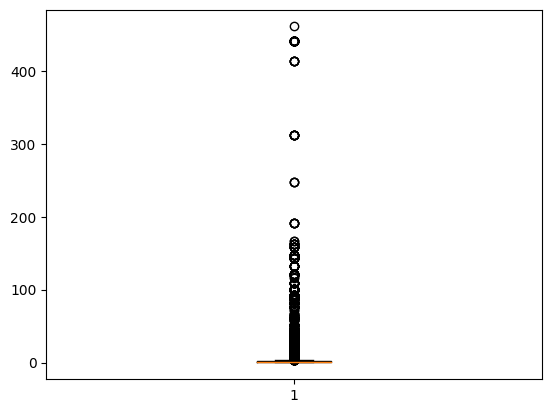

In [100]:
attrs = ['stays_in_week_nights', 'stays_in_weekend_nights', 'days_in_waiting_list']

a = mahal_dists(df[attrs])
plt.boxplot(a)
a.mean()
df[a > 100][attrs]

In [98]:
a =  z_score(df['required_car_parking_spaces'])
df[np.abs(a) > 3]['required_car_parking_spaces']

1        1
14       1
64       1
71       1
139      1
        ..
61816    1
61826    1
61833    1
61886    1
61890    1
Name: required_car_parking_spaces, Length: 3071, dtype: int64

# Otros

Text(0.5, 1.0, 'comparacion de market segments')

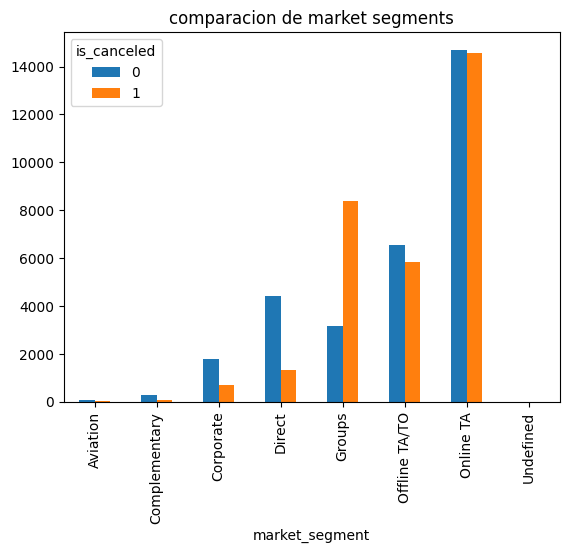

In [25]:
pd.crosstab(df['market_segment'], df['is_canceled']).plot(kind='bar')
plt.title("comparacion de market segments")

In [31]:
pd.crosstab(df['required_car_parking_spaces'], df['is_canceled']) ## los que cancelan no piden parking space, por ahi cancelan en 

is_canceled,0,1
required_car_parking_spaces,,
0,27900,30941
1,3058,0
2,12,0
3,1,0
8,1,0


In [58]:
df['reserved_room_type'].unique()

array(['D', 'A', 'F', 'E', 'G', 'B', 'C', 'H', 'P', 'L'], dtype=object)

In [59]:
df['assigned_room_type'].unique()

array(['D', 'A', 'F', 'E', 'H', 'C', 'G', 'B', 'I', 'K', 'P', 'L'],
      dtype=object)

In [66]:
pd.crosstab(df['assigned_room_type'], df['reserved_room_type'])

reserved_room_type,A,B,C,D,E,F,G,H,L,P
assigned_room_type,,,,,,,,,,
A,39805,52,3,134,7,2,4,0,0,0
B,513,517,1,13,2,8,2,0,0,0
C,649,0,464,12,2,0,0,0,0,0
D,3203,3,1,8971,9,2,0,1,0,0
E,490,1,2,297,2973,16,0,0,0,0
F,188,1,2,69,195,1358,8,0,0,0
G,66,4,2,41,40,57,1064,3,0,0
H,42,0,5,3,1,1,3,329,0,0
I,87,0,2,26,15,6,8,1,0,0


In [71]:
df['reserved_room_was_assigned'] = df.assigned_room_type == df.reserved_room_type

pd.crosstab(df.is_canceled, df.reserved_room_was_assigned)

reserved_room_was_assigned,False,True
is_canceled,,
0,5852,25120
1,572,30369


In [78]:
print(df[z_score(df['stays_in_week_nights'])  > 3]['stays_in_week_nights'])
df[z_score(df['stays_in_weekend_nights'])  > 3]['stays_in_weekend_nights']

6         9
214      10
287      10
325      10
454      19
         ..
61691    12
61705    10
61747    10
61840    11
61865    10
Name: stays_in_week_nights, Length: 846, dtype: int64


6        4
94       4
113      4
140      4
214      4
        ..
61691    5
61705    4
61747    4
61840    5
61865    4
Name: stays_in_weekend_nights, Length: 1116, dtype: int64

In [ ]:
l = ['lead_time', 'adr', 'stays_in_weekend_nights', 'booking_changes']

fig, ax = plt.subplots(len(l)//2,  len(l)//2  + len(l) % 2, figsize=(15,15))
ax = ax.flatten()

for i, cat in enumerate(l):
    df_cancelado[cat].hist(bins=40, alpha=0.7, label='cancelado', ax=ax[i])
    df_no_cancelado[cat].hist(bins=40, alpha=0.5, label='no cancelado', ax=ax[i])
    ax[i].set_title(cat)
    ax[i].legend()